In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion

In [4]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


### Request HPC Resources

In [5]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=2)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.68:36354 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.68:36354,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load in data

In [6]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp125_budgets_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
ds = ds.fillna(0.) #remove all NaNs

In [32]:
antarctic = regions[0]
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

In [61]:
ds['mask'] = (
    (ds['deptho'] <= 1100) & 
    (ds['geolat'] <= -40)
)


grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")
grid._ds = grid._ds.assign_coords({
    "sigma2_l_target": grid._ds['sigma2_l'].rename({"sigma2_l":"sigma2_l_target"}),
    "sigma2_i_target": grid._ds['sigma2_i'].rename({"sigma2_i":"sigma2_i_target"}),
})
grid = xwmt.add_gridcoords(
    grid,
    {"Z_target": {"center": "sigma2_l_target", "outer": "sigma2_i_target"}},
    {"Z_target": "extend"}
)

regions = MaskRegions(ds.mask, grid).region_dict


In [62]:
antarctic = regions[0]
region = GriddedRegion("antarctic", antarctic.lons, antarctic.lats, grid, ij=(antarctic.i, antarctic.j))

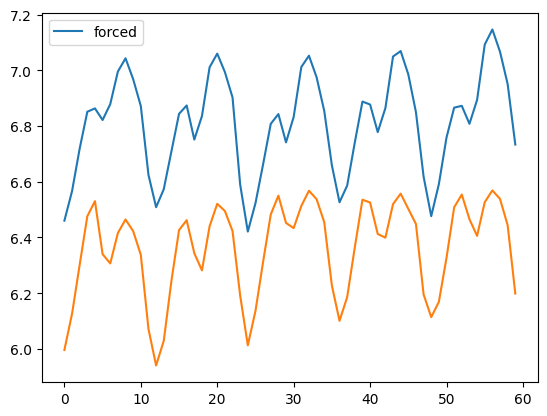

In [63]:
tmp = ds.thetao.mean(["sigma2_l", "yh", "xh"]).compute()
plt.plot(tmp.isel(exp = 0), label = tmp.isel(exp = 0).exp.values)
plt.plot(tmp.isel(exp = 1))
plt.legend()

Text(0.5, 1.0, 'Southern Ocean mask')

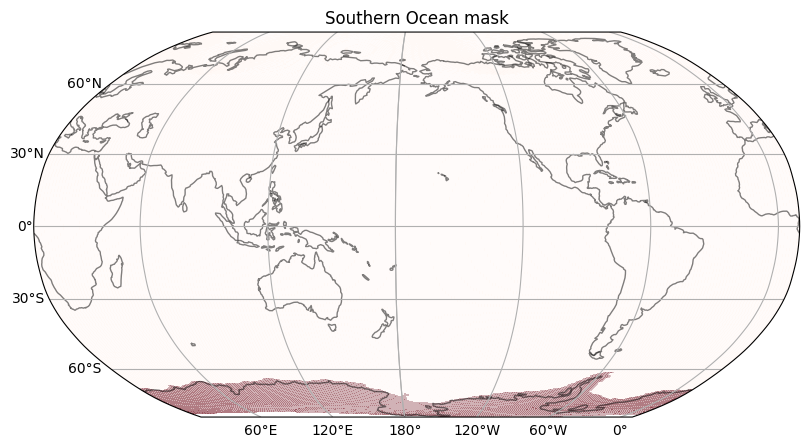

In [64]:
fig, ax = plt.subplots(figsize=[20,5], subplot_kw={'projection':ccrs.Robinson(190)})
ax.pcolormesh(ds['geolon'], ds['geolat'] , region.mask, 
              transform = ccrs.PlateCarree(), cmap = "Reds", alpha = 0.3)
ax.coastlines(alpha = 0.5)
gl = ax.gridlines(draw_labels = True)
gl.top_labels = False
gl.right_labels = False
ax.set_title("Southern Ocean mask")

### Define region with ``regionate``

### Collect budget terms and mass budget

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
    xbudget.collect_budgets(grid, budgets_dict)
    
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict, 
        region
    ) #if region not passed, the whole globe is taken
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, 
                    integrate=True, along_section=False)

### Extract time-mean mass budget

The closed numerical $\lambda$-WMT budget is given in Drake et. al 2024's Equation 43. The budget is given by: 
$$-\partial_t \mathcal{M}_\leq + \mathcal{S}_\leq + \Psi_\leq + \mathcal{G}^{BF}_\leq + \mathcal{G}^{Mix}_\leq + \mathcal{G}^{Spurious}_\leq = 0$$

Here: 
- $ \mathcal{M}(\tilde \lambda, t)_\leq = \int_\Omega \rho dV $ is the set of all waters bounded by a material surface $\tilde \lambda$
-  $\partial_t \mathcal{M}_\leq$ the rate of change of the mass of that water that is bounded by $\tilde \lambda$
    - $\tilde \lambda$ can be a density, so that $\partial_t \mathcal{M}_\leq$ describes the actual mass of waters denser than $\tilde \lambda$
    - When $\tilde \lambda$ is a density surface, $\partial_t \mathcal{M}_\leq > 0$ implies the mass of waters denser than $\tilde \lambda$ is decreasing
- If the region $\omega$ contains open boundaries (i.e. the focus is on a particular ocean), then mass is not conserved. Mass can enter freely via ocean circulation. This movement of mass along the horizontal boundaries is given by $\Psi_\leq$.
- $\mathcal{G}^{BF}_\leq$ is the contribution of mass change from boundary fluxes including mixing processes at the surface, seafloor and sea-ice.
- $\mathcal{G}^{Mix}_\leq$ includes the effects of parameterized mixing
- $\mathcal{G}^{Spurious}_\leq$ includes the effects of spurios mixing, from a models advection scheme. Obtained as a residual. 


In [45]:
# Key water mass transformation budget terms
budget_terms = ['Eulerian_tendency', 'advection', 'diffusion', 
                'boundary_fluxes', 'convergent_mass_transport', 
               'mass_tendency', 'mass_source', 'spurious_numerical_mixing', 
               "surface_exchange_flux", "bottom_flux", "frazil_ice", 
                "surface_ocean_flux_advective_negative_rhs"]


### Checking the total budget

In [46]:
wmt = wmb.wmt[budget_terms].compute()
wmt = wmt.assign_coords({"sigma2_i_target": wmb.wmt["sigma2_i_target"].compute()})

In [47]:
toSv = 1e-6/1035.

tend = toSv * wmt["mass_tendency"]

bterms = ['diffusion', 'boundary_fluxes', 'convergent_mass_transport', 
          'mass_source', 'spurious_numerical_mixing']
rem_budg = 0 * tend
for b in bterms:
    rem_budg += toSv * wmt[b]

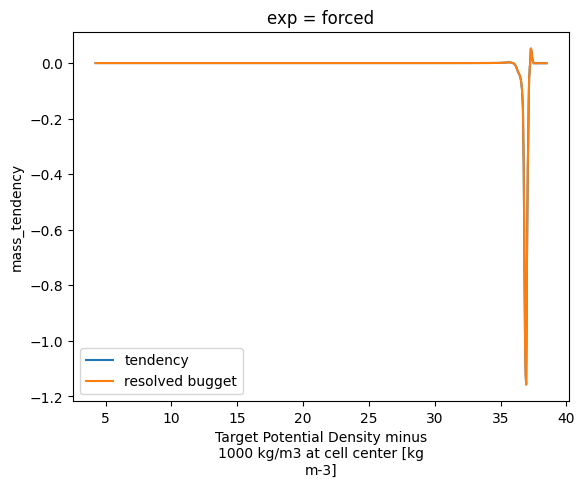

In [48]:
fig, ax = plt.subplots()
tend.mean("time").isel(exp = 0).plot(ax = ax, label = "tendency")
rem_budg.mean("time").isel(exp = 0).plot(ax = ax, label = "resolved bugget")
ax.legend()

### Checking the boundary flux budget

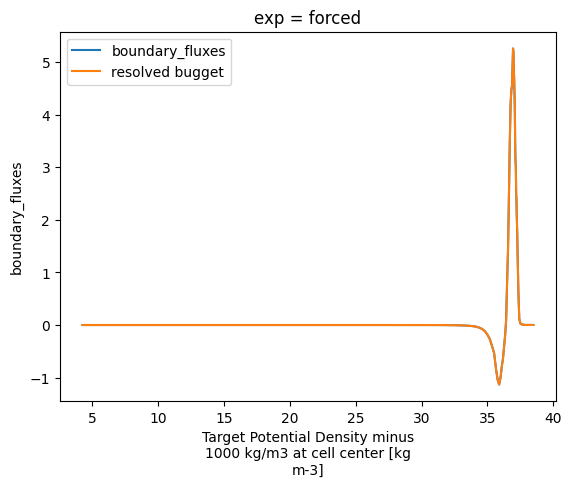

In [49]:
toSv = 1e-6/1035.

tend = toSv * wmt["boundary_fluxes"]

bterms = ["surface_exchange_flux", "bottom_flux", "frazil_ice", 
          "surface_ocean_flux_advective_negative_rhs"]
rem_budg = 0 * tend
for b in bterms:
    rem_budg += toSv * wmt[b]

fig, ax = plt.subplots()
tend.mean("time").isel(exp = 0).plot(ax = ax, label = "boundary_fluxes")
rem_budg.mean("time").isel(exp = 0).plot(ax = ax, label = "resolved bugget")
ax.legend()

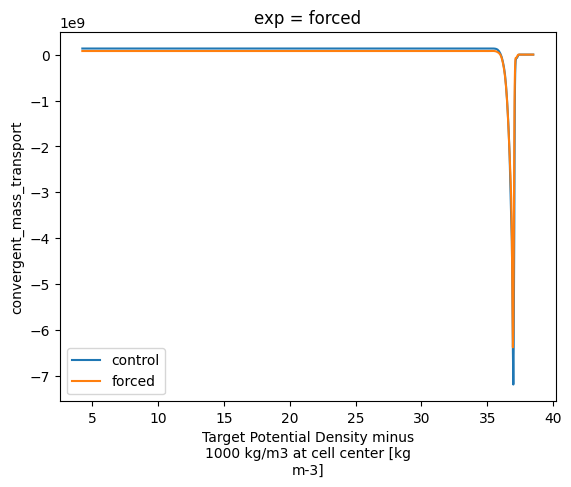

In [60]:
wmt["convergent_mass_transport"].sel(exp = "control").mean("time").plot(label = "control")
wmt["convergent_mass_transport"].sel(exp = "forced").mean("time").plot(label = "forced")
plt.legend()

### Checking the boundary flux tendency budget for $\sigma = 37.22$

5
5


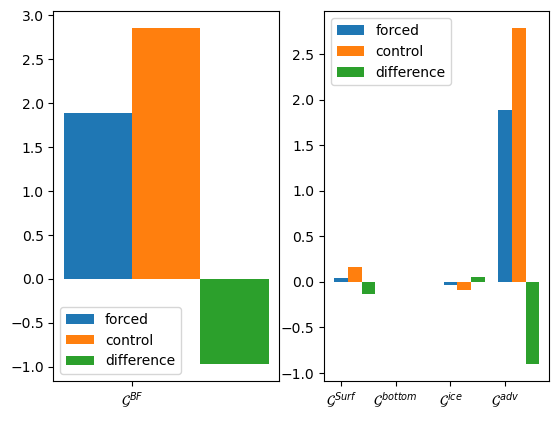

In [44]:
wmt_mean = toSv * wmt.sel(sigma2_l_target = 37.22, method = "nearest")

difference = -wmt_mean.diff(dim = "exp")
difference.coords['exp'] = ["difference"]
wmt_mean = xr.merge([wmt_mean, difference])
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

budgets = ['boundary_fluxes', 
           "surface_exchange_flux", #e.g., turbulent air-sea fluxes, radiative heating/cooling, sea ice brine rejection
           "bottom_flux", 
           "frazil_ice", 
          "surface_ocean_flux_advective_negative_rhs", #e.g., precipitation, evaporation, sea ice melt
          ]

budgets_labels = [r"$\mathcal{G}^{BF}$", 
                  r"$\mathcal{G}^{Surf}$",
                  r"$\mathcal{G}^{bottom}$",
                  r"$\mathcal{G}^{ice}$", 
                  r"$\mathcal{G}^{adv}$"]

print(len(budgets))
print(len(budgets_labels))

fig, ax = plt.subplots(1, 2, sharey = False)

width = 0.25
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)
    bvalues = [wmt_mean_budget[k].values for k in budgets]

    ax[0].bar(0 + curr_width, bvalues[0], label = exp, width = width)

    nterms = np.arange(len(budgets_labels[1:]))

    ax[1].bar(nterms + curr_width, bvalues[1:], label = exp, width = width)
    curr_width += width
    
[a.legend() for a in ax]

ax[0].set_xticks([width / 2], [budgets_labels[0]]);
ax[1].set_xticks(np.arange(len(budgets_labels[1:])), budgets_labels[1:]);

### Checking the mass budget for $\sigma = 37.22$

-0.015237457333265444
-0.01074295967881486
-0.004494497654450584


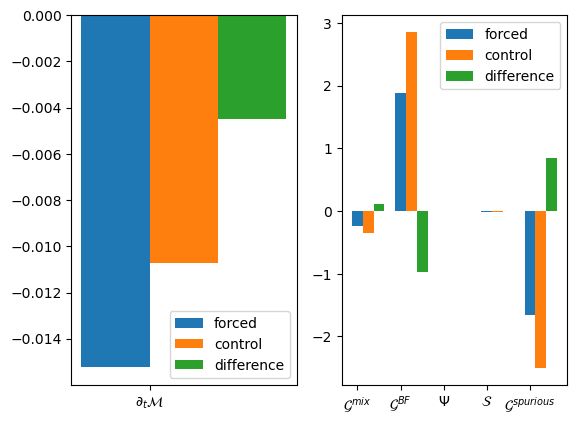

In [43]:
wmt_mean = toSv * wmt.sel(sigma2_l_target = 37.22, method = "nearest")

difference = -wmt_mean.diff(dim = "exp")
difference.coords['exp'] = ["difference"]
wmt_mean = xr.merge([wmt_mean, difference])
experiments = ['forced', 'control', 'difference']
nexpt = len(experiments)

budgets = ['mass_tendency', 
           'diffusion', 
           'boundary_fluxes', 
           'convergent_mass_transport', 
           'mass_source', 
           'spurious_numerical_mixing']

budgets_labels = [r"$\partial_{t} \mathcal{M}$", 
                  r"$\mathcal{G}^{mix}$",
                  r"$\mathcal{G}^{BF}$", 
                  r"$\Psi$", 
                  r"$\mathcal{S}$", 
                  r"$\mathcal{G}^{spurious}$"]
fig, ax = plt.subplots(1, 2, sharey = False)

width = 0.25
curr_width = 0.0
for (i, exp) in enumerate(experiments):
    wmt_mean_budget =  wmt_mean.sel(exp = exp)
    print(wmt_mean_budget['mass_tendency'].values)
    bvalues = [wmt_mean_budget[k].values for k in budgets]

    ax[0].bar(0 + curr_width, bvalues[0], label = exp, width = width)

    nterms = np.arange(len(budgets_labels[1:]))

    ax[1].bar(nterms + curr_width, bvalues[1:], label = exp, width = width)
    curr_width += width
    
[a.legend() for a in ax]

ax[0].set_xticks([width / 2], [budgets_labels[0]]);
ax[1].set_xticks(np.arange(len(budgets_labels[1:])), budgets_labels[1:]);

In [58]:
integrate = lambda x: np.cumsum(np.concatenate([[0.], x.values]))
tendencies = toSv * wmb.wmt.sel(sigma2_l_target = 37.22, method = "nearest").compute()

Text(0.5, 0.98, 'Southern Ocean Mass Budget Terms')

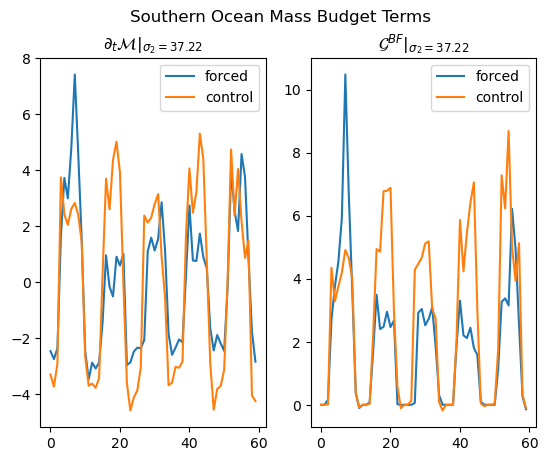

In [59]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(tendencies["mass_tendency"].isel(exp = 0), label = "forced")
ax[0].plot(tendencies["mass_tendency"].isel(exp = 1), label = "control")
ax[0].legend()

ax[1].plot(tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 0), label = "forced")
ax[1].plot(tendencies["surface_ocean_flux_advective_negative_rhs"].isel(exp = 1), label = "control")
ax[1].legend()

ax[0].set_title(r"$\partial_{t} \mathcal{M}|_{\sigma_2 = 37.22}$")
ax[1].set_title(r"$\mathcal{G}^{BF}|_{\sigma_2 = 37.22}$")

fig.suptitle("Southern Ocean Mass Budget Terms")